## Notebook to Fit Binary Models with Astrometry+RV

In [174]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,binary_model_combined
from orbit_plotting import orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [175]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [176]:
###########################################
## SETUP PATHS
###########################################

if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/orb6orbits.sql.txt'

## Read in Data:

In [177]:
###########################################
## Specify Target
###########################################
target_hd = '1976'
note = 'innerorbit'

#emethod = input('bootstrap errors? (y/n) ')
emethod = 'n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 1921
WDS 00243+5201
00243+5201


In [178]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## Read in RV data
file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))
weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
file_rv.close()

reading chi2 errors


Err for RV [1 km/s]:  5


In [179]:
### correct PAs based on precession (only for WDS):
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [180]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = input('Apply etalon correction? (y/n) ')

## FIXME: make it easier to choose vlti data
vlti = input('Add indices for vlti (y/n)? ')
#vlti = 'y'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
    
    vlti_mask = np.ones(len(t),dtype=bool)
    vlti_mask[vlti_idx] = False
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

   date      etalon factor
59044.4081 1.0002019414441545
59157.3052 1.0001077438236834


Apply etalon correction? (y/n)  y
Add indices for vlti (y/n)?  n


Applying etalon correction


## Run below cell for WDS file read-in

In [181]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'n'
if input_wds == 'y':
    try:
        file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
        weight = 10
        dtype = input('dtype for wds (e.g. S, leave blank for ALL data): ')

        t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
        print('Number of WDS data points = %s'%len(p_wds))

        ## correct WDS for PA
        theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)

        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        try:
            idx = np.argmin(t)
            plt.plot(xpos[idx],ypos[idx],'*')
            plt.plot(xpos,ypos,'+',label='ARMADA')
        except:
            pass
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        flip = input('Flip WDS data? (y/n): ')
        if flip=='y':
            xpos_wds=-p_wds*np.sin(theta_wds)
            ypos_wds=-p_wds*np.cos(theta_wds)
            plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
            plt.plot(xpos_wds[0],ypos_wds[0],'*')
            try:
                plt.plot(xpos[idx],ypos[idx],'*')
                plt.plot(xpos,ypos,'+',label='ARMADA')
            except:
                pass
            plt.plot(0,0,'*')
            plt.gca().invert_xaxis()
            plt.title('All Data')
            plt.xlabel('dra (mas)')
            plt.ylabel('ddec (mas)')
            plt.legend()
            plt.show()

            better = input('Flip data back to original? (y/n): ')
            if better=='y':
                xpos_wds=p_wds*np.sin(theta_wds)
                ypos_wds=p_wds*np.cos(theta_wds)
    except:
        t_wds = np.array([np.nan])
        p_wds = np.array([np.nan])
        theta_wds = np.array([np.nan])
        error_maj_wds = np.array([np.nan])
        error_min_wds = np.array([np.nan])
        error_pa_wds = np.array([np.nan])
        error_deg_wds = np.array([np.nan])
        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)
        print('NO WDS NUMBER')
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

NO WDS DATA


## Run below cell for WDS from a previous fit

In [ ]:
file_wds = open('/Users/tgardne/ARMADA_orbits/HD1976_chi2err/HD_1976_wds.txt')
p_wds=[]
degrees_wds=[]  #text file is in degrees
t_wds=[]
t_date_wds=[]
error_maj_wds=[]
error_min_wds=[]
error_pa_wds=[]
for line in file_wds.readlines():
    if line.startswith('#'):
        continue
    p_wds.append(float(line.split()[2]))
    degrees_wds.append(float(line.split()[3]))
    t_wds.append(float(line.split()[1]))
    t_date_wds.append(line.split()[0])
    if line.split()[4]=='--':
        error_maj_wds.append(0.1)
        error_min_wds.append(0.1)
        error_pa_wds.append(0)
    else:
        error_maj_wds.append(float(line.split()[4]))
        error_min_wds.append(float(line.split()[5]))
        epa = float(line.split()[6])
        #if epa>0:
        #    epa=90-epa
        #else:
        #    epa=abs(epa)+90
        error_pa_wds.append(epa)
file_wds.close()
degrees_wds=np.array(degrees_wds)
p_wds=np.array(p_wds)
t_wds=np.array(t_wds)
theta_wds=np.array(degrees_wds)*(np.pi/180)

error_maj_wds=weight*np.asarray(error_maj_wds)
error_min_wds=weight*np.asarray(error_min_wds)

error_deg_wds=np.asarray(error_pa_wds)
error_pa_wds=error_deg_wds*np.pi/180.

####################
## Plot to check:
####################
xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
try:
    idx = np.argmin(t)
    plt.plot(xpos[idx],ypos[idx],'*')
    plt.plot(xpos,ypos,'+',label='ARMADA')
except:
    pass
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [182]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6. Will need to enter your own.')

self_params = 'y'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
214.0 169.29 0.163 64.8 311.8 30.1 35130.04553200002
--------------------------


a (mas):  2
P (year):  0.07
ecc :  0.13
inc (deg):  99
omega (deg):  340
bigomega (deg):  340
T (mjd):  58581


In [183]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

if vlti=='y':
    vlti_mask_all = np.ones(len(t_all),dtype=bool)
    vlti_mask_all[vlti_idx] = False

## Fit Outer Binary

In [184]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa,d_rv,trv,err_rv):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(binary_model_combined_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx],d_rv,t_rv,err_rv),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(binary_model_combined, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa,d_rv,t_rv,err_rv),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']
    
    K_start = result.params['K']
    gamma_start = result.params['gamma']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()
    
    #Calculate the mean anamoly for each t in dataset:
    t0rv = np.linspace(min(trv),max(trv),1000)
    M=[]
    for i in t0rv:
        m_anom=2*np.pi/P_start*(i-T_start)
        M.append(m_anom)
    M=np.asarray(M)
    #eccentric anamoly calculated for each t (using kepler function):
    E=[]
    for j in M:
        #e_anom=keplerE(j,e)
        e_anom=ks.getE(j,e_start)
        E.append(e_anom)
    E=np.asarray(E)

    #Find velocity for model, compare to v1
    v = 2*np.arctan(np.sqrt((1+e_start)/(1-e_start))*np.tan(E/2))
    w_rv = (w_start+180)*np.pi/180
    model = K_start*(np.cos(w_rv+v)+e*np.cos(w_rv))+gamma_start
    
    foldtime= foldAt(trv,P_start,T0=T_start)
    tt_fold=foldAt(t0rv,P_start,T0=T_start)
    
    plt.errorbar(foldtime,d_rv,yerr=err_rv,fmt='o')
    plt.plot(tt_fold,model,'.')
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 55
    # variables        = 9
    chi-square         = 51.7024759
    reduced chi-square = 1.12396687
    Akaike info crit   = 14.5994866
    Bayesian info crit = 32.6654853
[[Variables]]
    w:           339.396063 +/- 21.4483164 (6.32%) (init = 338.87)
    bigw:        297.732829 +/- 10.0570539 (3.38%) (init = 340)
    inc:         8.6810e-04 +/- 1259075.37 (145038839851.44%) (init = 99)
    e:           0.14203529 +/- 0.04503213 (31.70%) (init = 0.129)
    a:           1.37945801 +/- 0.25517984 (18.50%) (init = 2)
    P:           25.4167975 +/- 8.3882e-04 (0.00%) (init = 25.4167)
    T:           58581.3179 +/- 1.76204936 (0.00%) (init = 58581.29)
    K:           23.0103313 +/- 1.22456548 (5.32%) (init = 23)
    gamma:      -9.66081545 +/- 0.85049731 (8.80%) (init = -9.7)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.971

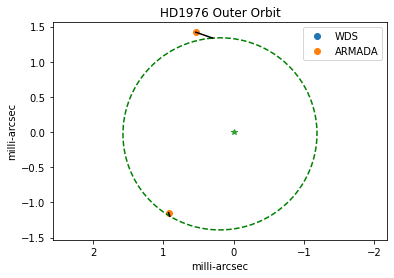

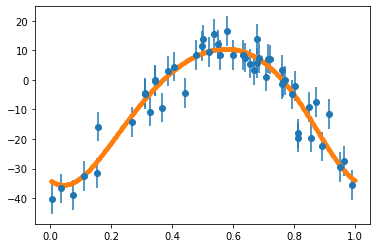

In [185]:
params = Parameters()
params.add('w',   value= 338.87, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= 0.129, min=0, max=0.99)
params.add('a', value= a)
params.add('P', value= 25.4167, min=0)
params.add('T', value= 58581.288, min=0)
params.add('K', value= 23)
params.add('gamma', value= -9.7)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all,rv,t_rv,err_rv)

In [ ]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle, d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Run below cell for TRIPLE + RV1 Fit:

In [ ]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

circular = 'y'
P2_guess = 2.03
i2_guess = 90
a2_guess = 0.17

K_guess = 30
gamma_guess = 0

for i in tqdm(np.arange(50)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(min(t)-P2_guess,max(t)+P2_guess)
    if i2_guess == 'n':
        inc2 = random.uniform(0,180)
    else:
        inc2 = i2_guess
        
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0, max=360)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
        
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2_guess, min=0)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)

    params.add('K', value= K_guess, min=0)
    params.add('gamma', value= gamma_guess)

    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    K_best.append(result.params['K'])
    gamma_best.append(result.params['gamma'])

In [ ]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

K_best = np.array(K_best)
gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

K_best = K_best[idx]
gamma_best = gamma_best[idx]

In [ ]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

params.add('K', value= K_best, min=0)
params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

In [ ]:
## scale errors based on chi2
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],[],[],[],[],[],[])
    resids_vlti = triple_model_vlti(result.params,[],[],[],[],[],[],xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_chara = 2*sum(~np.isnan(xpos[vlti_mask]))
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-17)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-17)
    except:
        pass
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-19)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-19)
    except:
        pass
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

try:
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)
except:
    pass

In [ ]:
1/np.sqrt(0.6)

In [ ]:
## scale errors
armada_scale = 1
vlti_scale = 2
chara_scale = 1

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale

In [ ]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

params.add('K', value= K_best, min=0)
params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value

P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
mirc_scale_best = result.params['mirc_scale'].value

K_best = result.params['K'].value
gamma_best = result.params['gamma'].value

In [ ]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+P,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Plot RV results:
foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best*0.99,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
w_rv = (w2_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_triple_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Mass / Orbit Information

#mratio_err = ufloat(mratio.value,mratio.stderr)
#a1_err = ufloat(a1.value,a1.stderr)

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
plx_hip = ufloat(0.01849,0.00135)
#plx_gaia = ufloat(0.01496,0.00053)

## Radial Velocity parameters included
semi1 = P2_err*24*60*60*K_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
print(semi1)
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / (a2_err/1000)
#d_rv = semi1 / ((a2_err - a1_err)/1000)

print('Distance from HIP = ')
print(1/plx_hip)
#print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = ')
print(d_rv)

#d_err = 1/plx_hip
d_err = d_rv

#print(K2_err/K1_err)

In [ ]:
P_err.std_dev

In [ ]:
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P_err.nominal_value,
                                                                                                             P_err.std_dev,a_err.nominal_value,
                                                                                                             a_err.std_dev,e_err.nominal_value,
                                                                                                             e_err.std_dev,inc_err.nominal_value,
                                                                                                             inc_err.std_dev,w_err.nominal_value,
                                                                                                             w_err.std_dev,bigw_err.nominal_value,
                                                                                                             bigw_err.std_dev,T_err.nominal_value,
                                                                                                             T_err.std_dev,))
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P2_err.nominal_value,
                                                                                                             P2_err.std_dev,a2_err.nominal_value,
                                                                                                             a2_err.std_dev,e2_err.nominal_value,
                                                                                                             e2_err.std_dev,inc2_err.nominal_value,
                                                                                                             inc2_err.std_dev,w2_err.nominal_value,
                                                                                                             w2_err.std_dev,bigw2_err.nominal_value,
                                                                                                             bigw2_err.std_dev,T2_err.nominal_value,
                                                                                                             T2_err.std_dev,K_err.nominal_value,
                                                                                                             K_err.std_dev,gamma_err.nominal_value,
                                                                                                             gamma_err.std_dev,))

In [ ]:
print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

print('-'*10)
minner_tot = sum1-1.59
print('M1+M2=',minner_tot)

print('-'*10)
mratio = (minner_tot*(P2_err/365.25)**2)**(1/3)/d_err/(a2_err/1000) - 1
print('M2/M1=', mratio)

print('-'*10)
m1 = minner_tot / (1+1/mratio)
m2 = minner_tot - m1
print('M1=', m1)
print('M2=', m2)

In [ ]:
ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
print('a_inner = %s au'%ainner)
print('a_outer = %s au'%aouter)

print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

## Run Cell Below for a Quad + RV1 Fit

In [ ]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P3_best = []
a3_best = []
e3_best = []
w3_best = []
bigw3_best = []
inc3_best = []
T3_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

circular = 'y'
P2_guess = 6.2
P3_guess = 25.42

for i in tqdm(np.arange(50)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(min(t)-P2_guess,max(t)+P2_guess)
    inc2 = random.uniform(0,180)
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0, max=360)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    params.add('w3', value = 172, min=0, max=360)
    params.add('bigw3', value= 162, min=0, max=360)
    params.add('inc3', value= 100, min=0, max=180)
    params.add('e3', value= 0.12, min=0,max=0.99)
    params.add('a3', value= 0.4, min=0)
    params.add('P3', value= 25.42, min=0)
    params.add('T3', value= 52876.8, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
        
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= 0.1, min=0)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)

    params.add('K', value= 24, min=0)
    params.add('gamma', value= -10)

    if len(vlti_idx)>0:
        params.add('mirc_scale', value= 1.0)
    else:
        params.add('mirc_scale', value= 1.0, vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(quad_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all,rv,t_rv,err_rv),
                      nan_policy='omit')
    result = minner.minimize()
    
    P3_best.append(result.params['P3'])
    a3_best.append(result.params['a3'])
    e3_best.append(result.params['e3'])
    w3_best.append(result.params['w3'])
    bigw3_best.append(result.params['bigw3'])
    inc3_best.append(result.params['inc3'])
    T3_best.append(result.params['T3'])

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    K_best.append(result.params['K'])
    gamma_best.append(result.params['gamma'])

In [ ]:
P3_best = np.array(P3_best)
a3_best = np.array(a3_best)
e3_best = np.array(e3_best)
w3_best = np.array(w3_best)
bigw3_best = np.array(bigw3_best)
inc3_best = np.array(inc3_best)
T3_best = np.array(T3_best)

P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

K_best = np.array(K_best)
gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P3_best = P3_best[idx]
a3_best = a3_best[idx]
e3_best = e3_best[idx]
w3_best = w3_best[idx]
bigw3_best = bigw3_best[idx]
inc3_best = inc3_best[idx]
T3_best = T3_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

K_best = K_best[idx]
gamma_best = gamma_best[idx]

In [ ]:
print('chi2 = ', np.min(chi2_results))
print('P,a,e,i,w,bigw,T = ', P_best,a_best,e_best,inc_best,w_best,bigw_best,T_best)
print('P2,a2,e2,i2,w2,bigw2,T2 = ', P2_best,a2_best,e2_best,inc2_best,w2_best,bigw2_best,T2_best)
print('P3,a3,e3,i3,w3,bigw3,T3 = ', P3_best,a3_best,e3_best,inc3_best,w3_best,bigw3_best,T3_best)
print('K,gamma = ', K_best, gamma_best)

In [ ]:
##########################################
## Save Plots for Quadruple
##########################################
if len(vlti_idx)>0:
    resids_armada = quad_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = quad_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

circular = 'y'
if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+2*P,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_outer_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+4*P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_inner_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+P3_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner1_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+P2_best,1000)
ra,dec,rapoints,decpoints = quad_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        a3_best,e3_best,
                                        inc3_best,w3_best,bigw3_best,
                                        P3_best,T3_best,t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(a3_best,e3_best,inc3_best,
                                        w3_best,bigw3_best,P3_best,
                                        T3_best,t_all,tmodel)

ra_inner = ra - ra2 - ra3
dec_inner = dec - dec2 - dec3
rapoints_inner = rapoints - rapoints2 - rapoints3
decpoints_inner = decpoints - decpoints2 - decpoints3

xpos_inner = xpos_all - rapoints2 - rapoints3
ypos_inner = ypos_all - decpoints2 - decpoints3

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_inner2_quad.pdf'%(directory,target_hd))
plt.show()
plt.close()

In [ ]:
## Plot RV results:

foldtime= foldAt(t_rv,P3_best,T0=T3_best)
tt=np.linspace(T3_best,T3_best+P3_best*0.99,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P3_best*(i-T3_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e3_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
w_rv = (w3_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e3_best)/(1-e3_best))*np.tan(EE/2))
y1=K_best*(np.cos(w_rv+f)+e3_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P3_best,T0=T3_best)

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_quad_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
#mratio_err = ufloat(mratio.value,mratio.stderr)
a1_err = ufloat(a1.value,a1.stderr)
a_err = ufloat(a.value,a.stderr)
a2_err = ufloat(a2.value,a2.stderr)
P_err = ufloat(P.value,P.stderr)
P2_err = ufloat(P2.value,P2.stderr)
#K1_err = ufloat(K1.value,K1.stderr)
#K2_err = ufloat(K2.value,K2.stderr)
K3_err = ufloat(K3.value,K3.stderr)
e2_err = ufloat(e2.value,e2.stderr)
inc2_err = ufloat(inc2.value,inc2.stderr)

## distance from HIP/GAIA
plx_hip = ufloat(0.01285,0.00044)
plx_gaia = ufloat(0.01496,0.00053)

## Radial Velocity parameters included
semi1 = P2_err*24*60*60*K3_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err)
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / ((a2_err - a1_err)/1000)

print('Distance from HIP = %s pc'%(1/plx_hip))
print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = %s pc'%d_rv)

#d_err = 1/plx_hip
d_err = d_rv

#print(K2_err/K1_err)

In [ ]:
print(a1_err)
print(a2_err-a1_err)

mratio_err = (a2_err - a1_err) / a1_err
print(mratio_err)

In [ ]:
## mass ratio Ba/Bb
#mratio = (a_in-a2) / a_in

print('-'*10)
print('Masses from distance')
print('-'*10)
print('mass ratio Bb/Ba = %s'%mratio_err)

# masses
print('distance=%s pc'%d_err)

sum1 = ((a_err+a2_err)*d_err/1000)**3 / (P_err/365)**2
sum2 = (a2_err*d_err/1000)**3 / (P2_err/365)**2

print('M1+M2+M3 = %s Msun'%sum1)
print('M2+M3 = %s Msun'%sum2)

m3 = sum2/(1+mratio_err)
m2 = mratio_err*m3
m1 = sum1-m2-m3

print('M1 = %s Msun'%m1)
print('M2 = %s Msun'%m2)
print('M3 = %s Msun'%m3)

ainner = ((P2/365.25)**2 * (m2+m3))**(1/3)
aouter = ((P/365.25)**2 * (m2+m3+m1))**(1/3)
print('a_inner = %s Msun'%ainner)
print('a_outer = %s Msun'%aouter)

print(' ')

#semi1 = P2*24*60*60*K1*np.sqrt(1-e**2)/(2*np.pi)/1.496e8/np.sin(inc2)
#semi2 = mratio*semi1

#d_rv = (semi1+semi2) / (a2/1000)

#print('-'*10)
#print('Masses from orbit only')
#print('-'*10)
#print('mass ratio Bb/Ba = %s'%np.around(mratio,3))

# masses
#print('distance=%s pc'%np.around(d_rv,3))

#sum1 = (a*d_rv/1000)**3 / (P/365)**2
#sum2 = (a2*d_rv/1000)**3 / (P2/365)**2

#print('M1+M2 = %s Msun'%np.around(sum1,3))
#print('M2+M3 = %s Msun'%np.around(sum2,3))

#m3 = sum2/(1+mratio)
#m2 = mratio*m3
#m1 = sum1-m2-m3

#print('M1 = %s Msun'%np.around(m1,3))
#print('M2 = %s Msun'%np.around(m2,3))
#print('M3 = %s Msun'%np.around(m3,3))

In [ ]:
## hmags
hmag = ufloat(3.89,0.24)
f12 = ufloat(10.39,0.04)
f13 = ufloat(14.73,0.06)

f1 = 1 / (1+1/f12+1/f13)
f2 = f1/f12
f3 = f1/f13

print(f1,f2,f3)

h1 = hmag-2.5*umath.log(f1,10)
h2 = hmag-2.5*umath.log(f2,10)
h3 = hmag-2.5*umath.log(f3,10)

print(h1,h2,h3)

In [ ]:
## mutual inclination
i_err = ufloat(75.92,0.15)
i2_err = ufloat(79.76,0.33)
bigw_err = ufloat(120.19,0.28)
bigw2_err = ufloat(131.17,0.16)

theta = umath.acos(umath.cos(i_err*np.pi/180)*umath.cos(i2_err*np.pi/180)+
                   umath.sin(i_err*np.pi/180)*umath.sin(i2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
theta2 = umath.acos(umath.cos(i_err*np.pi/180)*umath.cos(i2_err*np.pi/180)-
                    umath.sin(i_err*np.pi/180)*umath.sin(i2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))


print(theta*180/np.pi)
print(theta2*180/np.pi)

In [ ]:
print(umath.cos((bigw_err-bigw2_err)*np.pi/180))
print(umath.cos((bigw_err-bigw2_err)*np.pi/180+np.pi))